# Distortion Method Induction

This is the inductive algorithm from the paper:<br> "*Distortion-guided sequence matching for comparing pipeline inspections*"<br> by Craig L Champlin and Salman Mohagheghi

Submited for publication (10/15/22) in:<br>
**Advances in Engineering Software (ADES)**

### Using this notebook:
The development of code notebooks has been impactful. They blend working code and documentation in a way that supports tremendous clarity and experimentation. If you have never used one before, there are a few things to be aware of...

Code sections must explicitly be executed

  * order matters
      * the first two sections, importing packages and importing data, need to run once
      * functions must be run before `main() `will work
      * other than that, not all sections need to be run

    

* The scope of variables outside of functions is global

  * The order in the document doesn't matter
  * One might change a value and cause previous sections to break
  * to fix this, rerun sections in order


### A note on data availability:
Recent news about the bombing of the Nordstream pipeline, as well as other acts of vandalism or terror, should make it clear that pipeline data is extremely sensitive. To that end, we have taken the following steps to obscure the data offered here :

1. We have released a minimal data set to support the induction only. There are only two columns for each event, odometry and event class. 
2. Event class values for reference points have been randomly aggregated. This has reduced the precision of the results that this data can generate since what may have been three different types of reference points, are now represented by only one.
3. The original index values are not included because they imply the amount of corrosion on a joint. This information could be misused.
4. Data for the hybrid method, using semantic Needleman-Wunsch, is too sensitive for release. It requires all columns from the event attribute vector. We are contemplating how to generate a synthetic data set for this.


## Version History

#### `2022 10 15` Public Version
* Adding comments

#### `2022 10 12` Public Version

* Streamline for public release


#### `2022 10 06` Clean Version

* Following the published algorithm
* Using the recursion in `incrik()`

(c) October 2022, Craig L Champlin<br>
LICENSE: GNU Affero General Public License v3.0<br>
https://choosealicense.com/licenses/agpl-3.0/

# Initializations - Run once

In [2]:
## Run this to start a session

import math
import numpy as np
import pandas as pd

from collections import deque

from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Import Data

In [3]:
## Run this to start a session

# Uncomment a row to choose dataset 
###
# dset = 'RC1'; AStartRow=3; BStartRow=2; AEndRow=3913; BEndRow=3865
# dset = 'RC2'; AStartRow=4; BStartRow=6; AEndRow=12875; BEndRow=12375
dset = 'RC3'; AStartRow=3; BStartRow=3; AEndRow=7902; BEndRow=7757
# dset = 'RC4'; AStartRow=0; BStartRow=0; AEndRow=388; BEndRow=386

# import data
fnameA = ('./Data/' + dset + '-A.csv')
fnameB = ('./Data/' + dset + '-B.csv')

colNames = ['wc','event']

dfA = pd.read_csv(fnameA, skiprows=2, header=0, names=colNames)
dfB = pd.read_csv(fnameB, skiprows=2, header=0, names=colNames)

# lowercase-erize strings for easy comparison
dfA['event']=dfA['event'].str.lower()
dfB['event']=dfB['event'].str.lower()

# cast as specific data types to keep things tidy
eventTypes = pd.CategoricalDtype(categories=['refpoint1',
                                             'refpoint2',
                                             'refpoint3',
                                             'refpoint4',
                                             'refpoint5',
                                             'weld'], ordered=False)

dataTypes = {
             'event':eventTypes,
             'wc':np.float_
             }

dfA.astype(dataTypes)
dfB.astype(dataTypes)

# visual confirmation
display(dfA)
display(dfB)

,wc,event
0,-8.56,refpoint2
1,-2.13,weld
2,-1.66,refpoint3
3,0.00,refpoint5
4,0.51,refpoint3
...,...,...
7901,296374.61,refpoint3
7902,296375.42,refpoint5
7903,296376.27,refpoint3
7904,296376.68,weld


,wc,event
0,-52.94,refpoint2
1,-1.29,weld
2,-0.87,refpoint3
3,0.00,refpoint5
4,0.95,refpoint3
...,...,...
7756,296086.44,refpoint3
7757,296087.40,refpoint5
7758,296088.38,refpoint3
7759,296088.78,weld


In [12]:
# How to display rows - for looking at data

print(dfA.loc[10:20])
print()
print(dfB.loc[10:20])

        wc      event
10    5.05       weld
11    6.98  refpoint2
12    8.89       weld
13   13.86       weld
14   15.75  refpoint2
15   17.87       weld
16   30.39       weld
17   48.50       weld
18   66.91       weld
19   85.35       weld
20  103.33       weld

        wc      event
10    4.80       weld
11    6.60  refpoint2
12    8.47       weld
13   13.36       weld
14   15.73  refpoint2
15   17.58       weld
16   30.09       weld
17   48.28       weld
18   66.68       weld
19   85.15       weld
20  103.17       weld


# Distortion Method Code

Per the paper

### Configuration is below the two functions
It is above the main routine so that it is convienient to tweak parameters and try them out.

In [13]:
def incrik(i,k,A,B,Dm1,W) :
    # increment i and k, matching event types only
    i = i + 1 ; k = k + 1
    
    ei = A.loc[i].loc['event']
    ek = B.loc[k].loc['event']
    
    # easy match, exit
    if (ei == ek) :
        return (i,k)
    
    # no match, look for one nearby
    xi = A.loc[i].loc['wc']
    xk = B.loc[k].loc['wc']
    
    ip = i ; kp = k
    
    nearb = True 
    while nearb :   # hold A, scan B
        kp = kp + 1
        xkp = B.loc[kp].loc['wc']
        ekp = B.loc[kp].loc['event']
        
        nearb = (ei != ekp) and (xkp - xk) < W and (kp < len(B)-1)
        
    neara = True
    while neara :   # hold B, scan A
        ip = ip + 1
        xip = A.loc[ip].loc['wc']
        eip = A.loc[ip].loc['event']
    
        neara = (eip != ek) and (xip - xi) < W and (ip < len(A)-1)
    
        
    if (ei != ekp) and (eip != ek) :  
        # no match found, recurse until match
        return incrik(i,k,A,B,Dm1,W)
    
    # one or more candidate pairs
    if (ei == ekp) and (eip == ek) :
        # dual matches
        DiA = xi - xkp ; DDiA = DiA - Dm1
        DkB = xip - xk ; DDkB = DkB - Dm1
        
        if abs(DDiA) < abs(DDkB) :
            return (i, kp)
        else :
            return (ip, k)
        
    if (ei == ekp) :
        # single match
        return (i, kp)
    else :
        return (ip, k)
    
    # error - jump to end
    return(AEndRow,BEndRow)

In [14]:
def scanw(i,k,A,B, Dm1,DD,et,psi) :
    # returns index of better match within w
    w = abs(DD) * psi
    bestk = k 
    
    xi = A.loc[i].loc['wc']
    xk = B.loc[k].loc['wc'] 
    ei = A.loc[i].loc['event']
    ek = B.loc[k].loc['event']
    
    kp = k + 1
    
    nearby = True
    while nearby :
        
        xkp = B.loc[kp].loc['wc'] 
        ekp = B.loc[kp].loc['wc'] 
        
        if (ei == ekp) :
            Dp = xi - xkp
            DDp = Dp - Dm1
            
            if (abs(DDp) < abs(DD)) and (abs(DDp) < et[ei]) :
                # better match found
                bestk = kp
                
        kp = kp + 1
        nearby = (xkp - xk) < w and (kp < len(B)-1)
    
    return bestk

In [15]:
# Good settings per example
###


### RC3
# bigW = 33
# psi = 1.3
# et = 7.0

## Configuration

All configurable parameters are here

In [16]:
# Initilizations- globally available

# target error threshold (\mathring{\varepsilon})
etMonoVal = 7.0                   # real
et = {'refpoint1':etMonoVal,
      'refpoint2':etMonoVal,
      'refpoint3':etMonoVal,
      'refpoint4':etMonoVal,
      'refpoint5':etMonoVal,
      'weld':etMonoVal}

# Capital W window (about the size of longest joints)
bigW = 33                       # real

# scan window factor of safety (w = DD * psi)
psi = 1.3                      # real

# boundary conditions
i = AStartRow
k = BStartRow

n = AEndRow
m = BEndRow


## Main routine

This may take a while.

It will say `Finished` when it is done.

In [17]:
# main()

xi = dfA.loc[i].loc['wc']
xk = dfB.loc[k].loc['wc']

D = xi - xk
DD = 0

match = True

S = deque()      # the output sequence

## Main Loop
while (i < n) and (k < m) :

    if match :
        S.append([i,k,D,DD])
        Dm1 = D  # last known good distortion value
    else :
        pass     # outlier, retain last Dm1

    match = False

    # get next pair of i and k
    i, k = incrik(i,k,dfA,dfB,Dm1,bigW) 
    ei = dfA.loc[i].loc['event']
    ek = dfB.loc[k].loc['event']

    xa = dfA.loc[i].loc['wc']
    xb = dfB.loc[k].loc['wc']
    D = xa - xb
    DD = D - Dm1

    if abs(DD) < et[ei] :
        # good match, next iteration
        match = True
        continue

    # Pair is an outlier, scan for better matches
    kp = scanw(i,k,dfA,dfB, Dm1,DD,et,psi)
    ip = scanw(k,i,dfB,dfA, Dm1,DD,et,psi)

    if (kp == k) and (ip == i) :
        # nothing better, make a gap, get next pair
        match == False
        continue

    # better match found
    match = True

    if ((kp - k) < (ip - i)) and (kp != k) :
        # kp is the better match
        i = i ; k = kp
    else :
        # ip is yhe better match
        i = ip ; k = k

    # end while

currentDateAndTime = datetime.now()
currentTime = currentDateAndTime.strftime("%H:%M:%S")
print('Finished at :', currentTime)

Finished at : 13:52:38


## Convert Pairs to a Dataset for graphing

Will display a sample of the data table when done.  Wait for it.

In [19]:
# colNames = ['idx','event','wc']

mapcols = ['i', 'wcA', 'eventA', 
           'dist','diff',
           'eventB', 'wcB', 'k']

dsS = pd.DataFrame(columns=mapcols)

# pairs.reverse()

for elem in S :
    i, k, dist, diff = elem
    
    wcA = dfA.loc[i].loc['wc']
    eventA = dfA.loc[i].loc['event']
    
    eventB = dfB.loc[k].loc['event']
    wcB = dfB.loc[k].loc['wc']
    
    dist = wcA - wcB
    diff = diff
    
    dsS = dsS.append({'i':i, 'wcA':wcA, 'eventA':eventA, 
           'dist':dist,'diff':diff,
           'eventB':eventB,'wcB':wcB,'k':k}, ignore_index=True)

    
currentDateAndTime = datetime.now()
currentTime = currentDateAndTime.strftime("%H:%M:%S")
print('Finished at :', currentTime)
    
display(dsS) 

Finished at : 13:55:10


,i,wcA,eventA,dist,diff,eventB,wcB,k
0,3,0.00,refpoint5,0.00,0,refpoint5,0.00,3
1,4,0.51,refpoint3,-0.44,-0.44,refpoint3,0.95,4
2,5,1.18,weld,-0.27,0.17,weld,1.45,5
3,6,2.02,refpoint4,-0.02,0.25,refpoint4,2.04,6
4,7,2.85,weld,0.06,0.08,weld,2.79,7
...,...,...,...,...,...,...,...,...
7607,7897,296371.65,weld,288.17,-0.02,weld,296083.48,7752
7608,7898,296372.58,refpoint4,288.19,0.02,refpoint4,296084.39,7753
7609,7899,296373.68,refpoint4,288.16,-0.03,refpoint4,296085.52,7754
7610,7900,296374.23,weld,288.20,0.04,weld,296086.03,7755


## Mean and Std Dev

In [20]:
print('   E(diff) = {:0.2f}'.format(dsS['diff'].mean()))
print('   sigma(diff) = {:0.2f}'.format(dsS['diff'].std()))

   E(diff) = 0.04
   sigma(diff) = 0.63


In [751]:
# Save the data set, uncomment

# dsS.to_csv(path_or_buf='./Data_Out ', + dset + ,'.csv')

## Plot the distortion

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 1080x576 with 0 Axes>

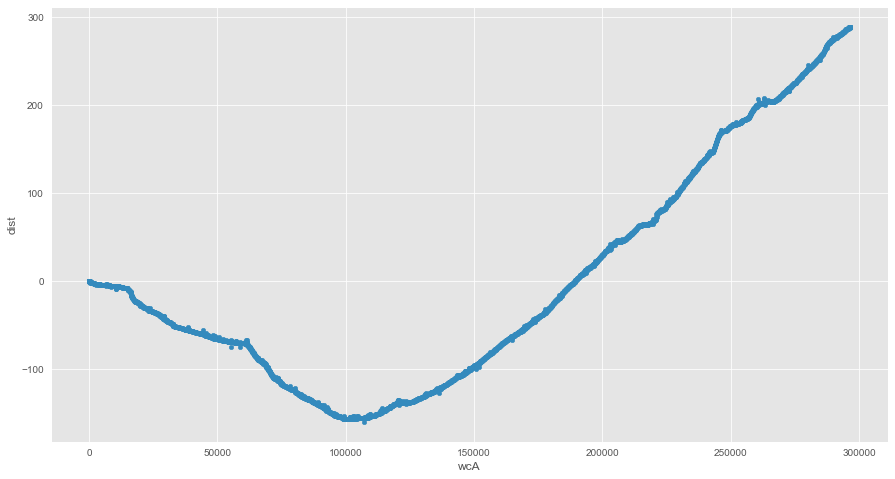

In [752]:
# Plot it
plt.figure(figsize=[15,8]);
dsS.plot(kind='scatter', x='wcA', y='dist', figsize=[15,8])
# , ylim=[-160,0], xlim=[0,107500]
plt.show

# plt.savefig('./Distortion ', + dset + ,'.pdf')
# plt.savefig('./Distortion ', + dset + ,'.png')

## Plot the Differencing

<function matplotlib.pyplot.show(close=None, block=None)>

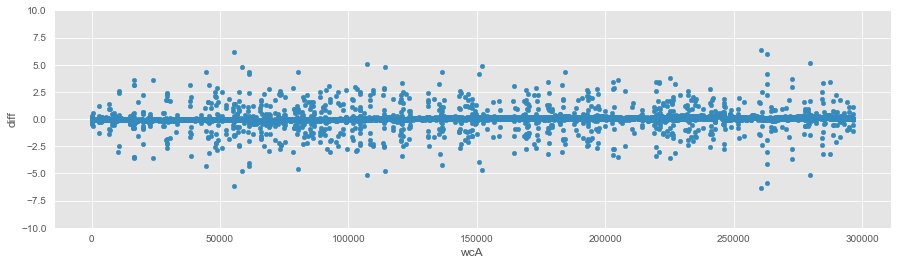

In [753]:
# Plot it
# plt.figure(figsize=[15,8]);
dsS.plot(kind='scatter', x='wcA', y='diff', figsize=[15,4], ylim=[-10,10])
# , ylim=[-160,0], xlim=[0,107500]
plt.show

# plt.savefig('./Differencing ', + dset + ,'.pdf')
# plt.savefig('./Differencing ', + dset + ,'.png')

In [748]:
# Grid Search

print(bigW, ' : bigW')
print(etMonoVal, ' : et')
print(psi, ' : psi')
print(i)
print(k)
print(len(S))  # <-- number of pairs found
print('Match % : ', round(len(S)/i * 100,2))


33  : bigW
7.0  : et
1.3  : psi
7902
7757
7612
Match % :  96.33
